<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/MVTEC_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title DEMO 준비_ 사전실행 [Run Me!!!!]

!gsutil cp gs://iskra3138_mvtec_tfrecords/my_mvtec_tpumodel.h5 ./
  
model_file = 'my_mvtec_tpumodel.h5'
activation_layer = 'conv5_block3_out'

%tensorflow_version 1.x

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image as Image
import cv2

import glob

import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops


import scipy
from scipy import ndimage
from skimage.measure import label, regionprops

%matplotlib inline

model = tf.keras.models.load_model(model_file)

#@title TFRecord Parsing Functions [Run Me!!!!]
import os

AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE =  [224, 224]

validation_fns = 'gs://iskra3138_mvtec_tfrecords/valid.tfrecords'

def parse_tfrecord(example):
    features = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    label = example['label']
    #label = tf.one_hot(indices=label, depth=2)
    image = tf.io.decode_jpeg(example['image_raw'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    
    return image, label

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def NG_filter_fn(img, label):
  return tf.math.equal(label, 0)
def OK_filter_fn(img, label):
  return tf.math.equal(label, 1)

def make_class_sapling (fns, class_idx, batch_size) :
  if class_idx == 0 :
    NG_dataset = load_dataset(fns).filter(NG_filter_fn).shuffle(1000).batch(batch_size).prefetch(AUTO).repeat()
    NG_iter = NG_dataset.make_one_shot_iterator()
    return NG_iter
  else :
    OK_dataset = load_dataset(fns).filter(OK_filter_fn).shuffle(1000).batch(batch_size).prefetch(AUTO).repeat()
    OK_iter = OK_dataset.make_one_shot_iterator()
    return OK_iter
    
    
#@title import Util Code [Run Me!!]
def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if tf.keras.backend.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_bbox(img, cam, threshold):
    labeled, nr_objects = ndimage.label(cam > threshold)
    props = regionprops(labeled)
    return props
  
#@title import Grad-CAM Code [Run Me!!]
class GradCAM:
  def __init__(self, model, activation_layer):
    self.model = model
    self.activation_layer = activation_layer
    self.gradient_fn = self._get_gradcam_tensor_function()

  # get partial tensor graph of CNN model
  def _get_gradcam_tensor_function(self):
    model_input = self.model.input
    class_idx = tf.argmax(model.output[0])
    
    y_c = self.model.outputs[0].op.inputs[0][0, class_idx]
    A_k = self.model.get_layer(self.activation_layer).output
    
    grads = K.gradients(y_c, A_k)[0]
    gradient_fn = K.function([model.input], [A_k, grads, model.output])
    return gradient_fn

  # generate Grad-CAM
  def generate(self, input_tensor):
    conv_output, grad_val, predictions = self.gradient_fn([input_tensor])
    conv_output, grad_val = conv_output[0], grad_val[0]
    
    weights = np.mean(grad_val, axis=(0, 1))
    gradcam = np.dot(conv_output, weights)
    
    gradcam = cv2.resize(gradcam, (224, 224))
    
    ## Relu
    gradcam = np.maximum(gradcam, 0)
    return gradcam, predictions[0]
  
#@title import Guided Grad-CAM Code [Run Me!!]

class GuidedGradCam:
    def __init__(self, model, activation_layer, method='GuidedBackProp'):
        self.model = model
        #self.model_func = model_func
        self.activation_layer = activation_layer

        if method == 'BackProp':
            self._register_backprop_gradient()
            self.guided_model = self._modify_graph('BackProp')
        elif method == 'DeconvNet':
            self._register_deconvnet_gradient()
            self.guided_model = self._modify_graph('DeconvNet')
        elif method == 'GuidedBackProp':
            self._register_guidedbackprop_gradient()
            self.guided_model = self._modify_graph('GuidedBackProp')
        else:
            sys.exit('method must be (BackProp, DeconvNet, GuidedBackProp)')

        self.tensor_function = self.get_tensor_function()

    # register gradient
    def _register_backprop_gradient(self):
        if "BackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("BackProp")
            def _BackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(op.inputs[0] > 0., dtype)

    def _register_deconvnet_gradient(self):
        if "DeconvNet" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("DeconvNet")
            def _DeconvNet(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype)

    def _register_guidedbackprop_gradient(self):
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * \
                       tf.cast(op.inputs[0] > 0., dtype)

    # modify model graph
    def _modify_graph(self, name):
        g = tf.get_default_graph()
        with g.gradient_override_map({'Relu': name}):
            new_model = tf.keras.models.load_model('my_mvtec_tpumodel.h5')
        return new_model

    # get partial tensor graph of CNN model
    def get_tensor_function(self, method='max', channel=0):
        model_input = self.guided_model.input
        layer_output = self.guided_model.get_layer(self.activation_layer).output

        '''if method == 'max':
            output = K.max(layer_output, axis=3)
        elif method == 'one':
            output = layer_output[:, :, :, channel]
        else:
            sys.exit('method must be (max, one)')'''

        tensor_function = K.function([model_input], [K.gradients(layer_output, model_input)[0]])
        return tensor_function

    # generate saliency map(gradient)
    def generate(self, input_tensor, gradcam):
        saliency = self.tensor_function([input_tensor])[0]
        guided_grad_cam = saliency * gradcam[...,np.newaxis]

        return guided_grad_cam[0]
      
gradcam_gen = GradCAM(model, activation_layer)
guided_gradcam_gen = GuidedGradCam(model, activation_layer)  

Copying gs://iskra3138_mvtec_tfrecords/my_mvtec_tpumodel.h5...
| [1 files][163.7 MiB/163.7 MiB]                                                
Operation completed over 1 objects/163.7 MiB.                                    
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# DEMO

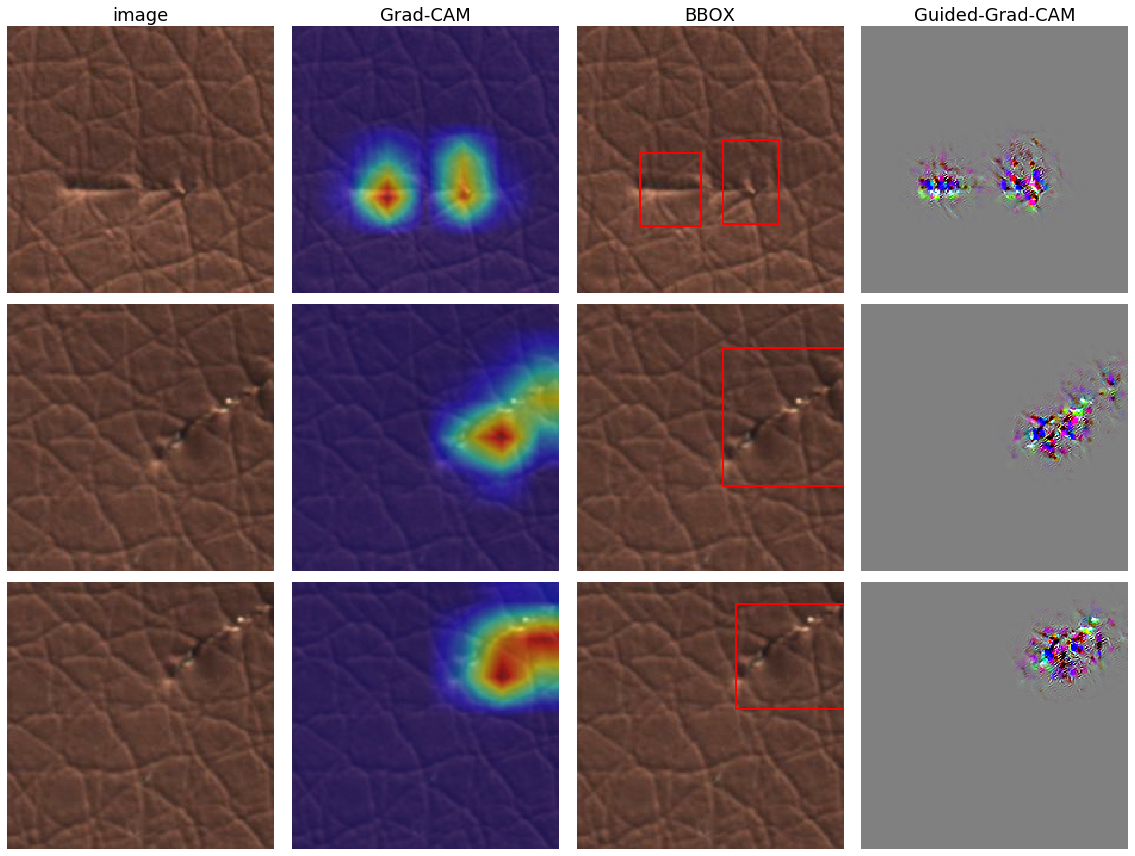

In [7]:
#@title NG Image TEST
sample_size = 3 # viualization할 이미지 개수
NG_iter = make_class_sapling(validation_fns, class_idx = 0, batch_size = sample_size)
NG_images, NG_labels = NG_iter.get_next()

with tf.Session() as sess:
  NG_imgs = sess.run(NG_images)
  
gradcams=[]
guided_gradcams=[]

for i, img in enumerate(NG_imgs):
    
    img_tensor = np.expand_dims(img, axis=0)
    
    gradcam, pred = gradcam_gen.generate(img_tensor)
    gradcams.append(gradcam)
    
    guided_gradcam = guided_gradcam_gen.generate(img_tensor, gradcam)
    guided_gradcams.append(guided_gradcam)
    
fig, axes = plt.subplots(sample_size, 4, figsize=(16, 12))
for i, img in enumerate(NG_imgs):

    img =img
    props = generate_bbox(img, gradcams[i], 0.5) # (원본이미지, gradcam값, BBOX 작성을 위한 threshold)
    
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(img)
    axes[i, 1].imshow(gradcams[i], cmap='jet', alpha=0.5)
    axes[i, 2].imshow(img)
    for b in props:
        bbox = b.bbox
        xs = bbox[1]
        ys = bbox[0]
        w = bbox[3] - bbox[1]
        h = bbox[2] - bbox[0]

        rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[i, 2].add_patch(rect)
        
    axes[i, 3].imshow(deprocess_image(guided_gradcams[i]))
    
    
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
    axes[i, 3].axis('off')
    
    axes[0, 0].set_title("image", fontsize=18)
    axes[0, 1].set_title("Grad-CAM", fontsize=18)
    axes[0, 2].set_title("BBOX", fontsize=18)
    axes[0, 3].set_title("Guided-Grad-CAM", fontsize=18)
    
plt.tight_layout()
plt.show()

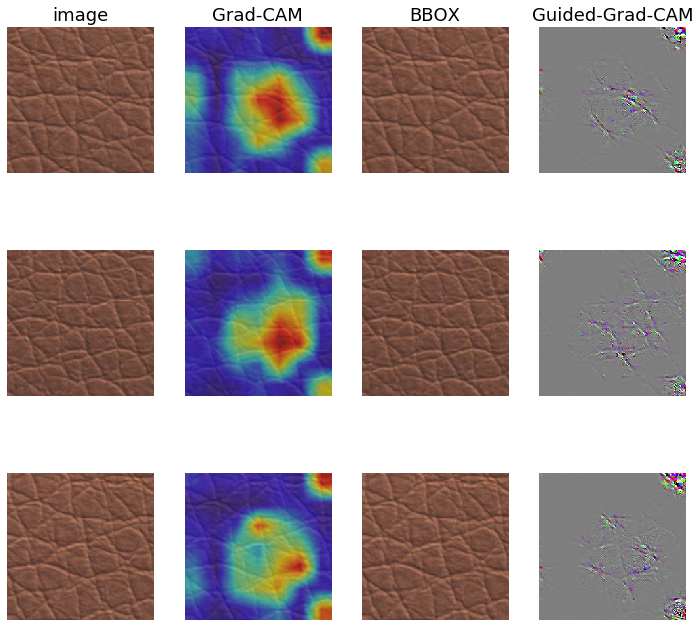

In [3]:
#@title OK Image TEST
sample_size = 3 # viualization할 이미지 개수
OK_iter = make_class_sapling(validation_fns, class_idx = 1, batch_size = sample_size)
OK_images, OK_labels = OK_iter.get_next()
with tf.Session() as sess:
  OK_imgs = sess.run(OK_images)
  
  
gradcams=[]
guided_gradcams=[]

for i, img in enumerate(OK_imgs):
    
    img_tensor = np.expand_dims(img, axis=0)
    
    gradcam, pred = gradcam_gen.generate(img_tensor)
    gradcams.append(gradcam)
    
    guided_gradcam = guided_gradcam_gen.generate(img_tensor, gradcam)
    guided_gradcams.append(guided_gradcam)
    
fig, axes = plt.subplots(sample_size, 4, figsize=(10, 10))
for i, img in enumerate(OK_imgs):

    img =img
    props = generate_bbox(img, gradcams[i], 0.5) # (원본이미지, gradcam값, BBOX 작성을 위한 threshold)
    
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(img)
    axes[i, 1].imshow(gradcams[i], cmap='jet', alpha=0.5)
    axes[i, 2].imshow(img)
    for b in props:
        bbox = b.bbox
        xs = bbox[1]
        ys = bbox[0]
        w = bbox[3] - bbox[1]
        h = bbox[2] - bbox[0]

        rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[i, 2].add_patch(rect)
        
    axes[i, 3].imshow(deprocess_image(guided_gradcams[i]))
    
    
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
    axes[i, 3].axis('off')
    
    axes[0, 0].set_title("image", fontsize=18)
    axes[0, 1].set_title("Grad-CAM", fontsize=18)
    axes[0, 2].set_title("BBOX", fontsize=18)
    axes[0, 3].set_title("Guided-Grad-CAM", fontsize=18)
    
plt.tight_layout()
plt.show()